## Research Question
Which S&P 500 companies have the highest influence on the stock market and why?

### Agenda
This project will magnify the true influence an individual S&P 500 company has on the stock market. True influence will be determined by the companies market capitalization (market cap), which is the total market value of a companies outstanding shares multiplied by its share price. Once analyzing which companies have the highest influence, I will attempt to decipher why.

### Spatial Scope
The spatial scope is the national (USA) market because the S&P 500 is limited to US companies.

### Data Sources
[S&P 500 Companies with Financial Information](https://datahub.io/core/s-and-p-500-companies-financials)
contains a list of all companies in the S&P 500, all stocks, as well as associated key financials (price, market capitalization, earnings, price/earnings ratio, etc.).

[Fortune 500 Corporate Headquarters](https://hifld-geoplatform.opendata.arcgis.com/datasets/fortune-500-corporate-headquarters/data)
contains a list of fortune 500 companies' headquarters (including: Address, Latitude, Longitude, etc.).

In [1]:
# the usuals
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx
from sodapy import Socrata
import plotly.express as px

# new for data viz
import seaborn as sns

# to explore point patterns
from pointpats import centrography
from matplotlib.patches import Ellipse
import numpy

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


Lets import S&P 500 companies financial information into a data frame and S&P 500 companies headquarter information as a geo data frame.

In [2]:
financials = ['Symbol', 'Name', 'Sector', 'Market Cap']
companies_df = pd.read_csv("constituents-financials_csv.csv", index_col = False, usecols = financials)
companies_df.head()

Symbol                 Name                  Sector    Market Cap
0    MMM           3M Company             Industrials  138721055226
1    AOS      A.O. Smith Corp             Industrials   10783419933
2    ABT  Abbott Laboratories             Health Care  102121042306
3   ABBV          AbbVie Inc.             Health Care  181386347059
4    ACN        Accenture plc  Information Technology   98765855553

In [3]:
companies_gdf = gpd.read_file("Fortune_500_Corporate_Headquarters.geojson")
locations = ['RANK', 'NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'COUNTY', 'LATITUDE', 'LONGITUDE', 'COUNTYFIPS', 'geometry']
companies_gdf = companies_gdf[locations]
companies_gdf.head()

RANK                         NAME                   ADDRESS        CITY  \
0   49.0              ALBERTSONS COS.  250 PARKCENTER BOULEVARD       BOISE   
1  226.0            MICRON TECHNOLOGY    8000 SOUTH FEDERAL WAY       BOISE   
2  290.0  LABORATORY CORP. OF AMERICA     358 SOUTH MAIN STREET  BURLINGTON   
3  440.0                 LAM RESEARCH      4650 CUSHING PARKWAY     FREMONT   
4  198.0                       SYNNEX         44201 NOBEL DRIVE     FREMONT   

  STATE    ZIP    COUNTY  LATITUDE  LONGITUDE COUNTYFIPS  \
0    ID  83706       ADA  43.59974 -116.18099      16001   
1    ID  83716       ADA  43.52925 -116.14697      16001   
2    NC  27215  ALAMANCE  36.09317  -79.43739      37001   
3    CA  94538   ALAMEDA  37.48860 -121.95694      06001   
4    CA  94538   ALAMEDA  37.49628 -121.97965      06001   

                      geometry  
0  POINT (-116.18099 43.59974)  
1  POINT (-116.14697 43.52925)  
2   POINT (-79.43739 36.09317)  
3  POINT (-121.95694 37.48860)  
4  POINT (-121.97965 37.49628)

Lets plot the companies by market cap.

In [4]:
fig = px.bar(companies_df,
           x='Name',
           y='Market Cap',
           title='S&P 500 Companies by Market Cap')
fig.show()
fig.write_html("S&P_Companies_by_Market_Cap.html")

We can clearly see that certain companies have huge market caps (greater than 600 Billion), lets find them.

In [5]:
companies_huge_df = companies_df[companies_df['Market Cap'] > 600000000000]
fig = px.bar(companies_huge_df,
           x='Name',
           y='Market Cap',
           title='Huge S&P 500 Companies by Market Cap')
fig.show()
fig.write_html("Huge_Companies_by_Market_Cap.html")

So the largest S&P 500 companies are Alphabet Inc., Amazon.com Inc., Apple Inc., and Microsoft Corp.

Lets find the companies that have smaller market caps (less than 5 Billion)

In [6]:
companies_small_df = companies_df[companies_df['Market Cap'] < 5000000000]
fig = px.bar(companies_small_df,
           x='Name',
           y='Market Cap',
           title='Small S&P 500 Companies by Market Cap')
fig.show()
fig.write_html("Small_Companies_by_Market_Cap.html")

So the smallest S&P 500 companies are Assurant Inc., Chesapeake Energy, Envision Healthchare, Navient, Patterson Companies, Range Resources Corp., and Signet Jewelers.

Lets see the headquarters on a US map.

In [7]:
fig = px.scatter_geo(companies_gdf,
           lon='LONGITUDE',
           lat='LATITUDE',
           size_max=10, 
           hover_name='NAME',
           scope='usa',
           color_continuous_scale = 'RdYlGn_r',
            )
fig.update_geos(fitbounds="locations")
fig.show()
fig.write_html("Scatter_geo_Companies_by_Market_Cap.html")

These dots represent the headquarters locations, but we still can't tell the difference between the market caps of each company.

So lets merge the two data frames in order to have market cap and geographic location in the same data frame.

In [8]:
companies_df['Name'] = companies_df['Name'].str.lower()
companies_gdf['NAME'] = companies_gdf['NAME'].str.lower()
companies_df.rename(columns={'Name':'NAME'}, inplace = True)

This is the tricky part because the names are written differently in each data frame, but lets give it a go.

In [9]:
for gdf_name in companies_gdf['NAME']:
    for df_name in companies_df['NAME']:
        if (gdf_name in df_name) or (df_name in gdf_name):
            companies_df.loc[companies_df['NAME'] == df_name, 'NAME'] = gdf_name
            break

In [10]:
companies_complete_gdf = companies_gdf.merge(companies_df, left_on = 'NAME', right_on = 'NAME')
companies_complete_gdf.head()

RANK                         NAME                 ADDRESS        CITY  \
0  226.0            micron technology  8000 SOUTH FEDERAL WAY       BOISE   
1  290.0  laboratory corp. of america   358 SOUTH MAIN STREET  BURLINGTON   
2  440.0                 lam research    4650 CUSHING PARKWAY     FREMONT   
3  219.0                  ross stores     5130 HACIENDA DRIVE      DUBLIN   
4  453.0                       clorox           1221 BROADWAY     OAKLAND   

  STATE    ZIP    COUNTY  LATITUDE  LONGITUDE COUNTYFIPS  \
0    ID  83716       ADA  43.52925 -116.14697      16001   
1    NC  27215  ALAMANCE  36.09317  -79.43739      37001   
2    CA  94538   ALAMEDA  37.48860 -121.95694      06001   
3    CA  94568   ALAMEDA  37.71041 -121.89039      06001   
4    CA  94612   ALAMEDA  37.80348 -122.27237      06001   

                      geometry Symbol                  Sector   Market Cap  
0  POINT (-116.14697 43.52925)     MU  Information Technology  48576791974  
1   POINT (-79.43739 36.09317)     LH             Health Care  17271388000  
2  POINT (-121.95694 37.48860)   LRCX  Information Technology  27967534829  
3  POINT (-121.89039 37.71041)   ROST  Consumer Discretionary  29803566306  
4  POINT (-122.27237 37.80348)    CLX        Consumer Staples  16540418002

Looks good, lets verify that nothing was lost...

In [11]:
companies_complete_gdf.shape

(291, 14)

Unfortunately, we lost about 200 companies...
However this is the best we can do with the companies names being so different. It would have been a very simple task if the company symbols appeared on both data frames for the symbols cannot be different (presumably).

Lets proceed with the ~300 companies we were able to merge succefully.

In [12]:
fig = px.scatter_geo(companies_complete_gdf,
           lon='LONGITUDE',
           lat='LATITUDE',
           color='Market Cap', 
           size='Market Cap',
           size_max=10, 
           hover_name='NAME',
           scope='usa',
           color_continuous_scale = 'RdYlGn_r',
           #range_color = (0,latimes_single_day_mean * 2) # double the mean 
            )
fig.update_geos(fitbounds="locations") 
fig.show()
fig.write_html("Companies_by_Market_Cap_geo.html")

Now this is more informative in visualizing were companies with huge market caps are located in the United States. We can clearly see that the biggest companies by market cap are located in California and Washington.

In [13]:
# scatterplot with edges
g = sns.jointplot(data = companies_gdf,
                  x='LONGITUDE', 
                  y='LATITUDE',
                  s=55)

The above joint plot shows us that a majority of S&P 500 companies tend to be located around North Eastern United States.

In [14]:
# compute the mean and median centers
mean_center = centrography.mean_center(companies_gdf[['LONGITUDE','LATITUDE']])
med_center = centrography.euclidean_median(companies_gdf[['LONGITUDE','LATITUDE']])
major, minor, rotation = centrography.ellipse(companies_gdf[['LONGITUDE','LATITUDE']])

In [15]:
# set the style without grid lines
sns.set_style('dark')

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(13, 13))

# Plot points
ax.scatter(companies_gdf['LONGITUDE'], companies_gdf['LATITUDE'], s=5)
ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

# Construct the standard ellipse using matplotlib
ellipse = Ellipse(xy=mean_center, # center the ellipse on our mean center
                  width=major*2, # centrography.ellipse only gives half the axis
                  height=minor*2, 
                  angle = numpy.rad2deg(rotation), # Angles for this are in degrees, not radians
                  facecolor='none', 
                  edgecolor='red', 
                  linestyle='--',
                  label='Std. Ellipse')

ax.add_patch(ellipse)

ax.legend()

ax.axis('off')

# add a basemap
ctx.add_basemap(ax,
                crs='epsg:4326',
                source=ctx.providers.CartoDB.Positron)

# Display
plt.show()

The above centrography plot shows us that mean center is slightly to the east of the center of the United States and the median center is more east and even slightly north of the center of the United States. The standard deviation ellipse shows that companies vary significantly more from east and west then north and south.

In [16]:
def company_ellipse(state):
    
    # filter the data by race
    state_filtered = companies_gdf[(companies_gdf.STATE == state)]

    # mean center and median
    mean_center = centrography.mean_center(state_filtered[['LONGITUDE','LATITUDE']])
    med_center = centrography.euclidean_median(state_filtered[['LONGITUDE','LATITUDE']])

    # standard ellipse
    major, minor, rotation = centrography.ellipse(state_filtered[['LONGITUDE','LATITUDE']])

    # Set up figure and axis
    f, ax = plt.subplots(1, figsize=(13, 13))

    # plot crime points
    ax.scatter(state_filtered['LONGITUDE'], state_filtered['LATITUDE'], s=3)

    # add the mean and median center points
    ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
    ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

    # Construct the standard ellipse using matplotlib
    ellipse = Ellipse(xy=mean_center, # center the ellipse on our mean center
                      width=major*2, # centrography.ellipse db_filtered
                      height=minor*2, 
                      angle = numpy.rad2deg(rotation), # Angles for this are in degrees, not radians
                      facecolor='none', 
                      edgecolor='red', linestyle='--',
                      label='Std. Ellipse')

    ax.add_patch(ellipse)

    # add the legend
    ax.legend()

    # no axix
    ax.axis('Off')

    # add a dynamic title
    ax.set_title("Companies in " + state)

    # add a basemap
    ctx.add_basemap(ax,
                    crs='epsg:4326',
                    source=ctx.providers.CartoDB.Positron)
    # Display
    plt.show()

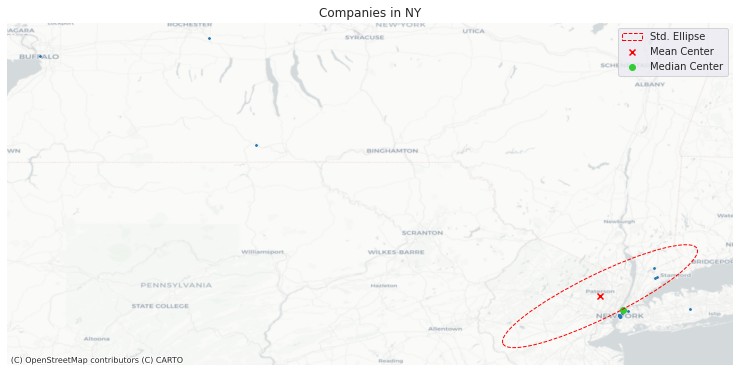

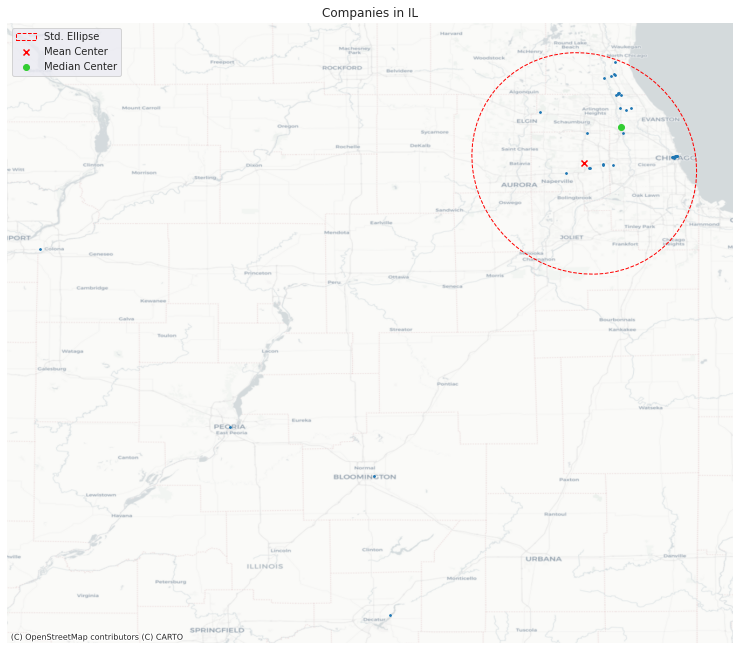

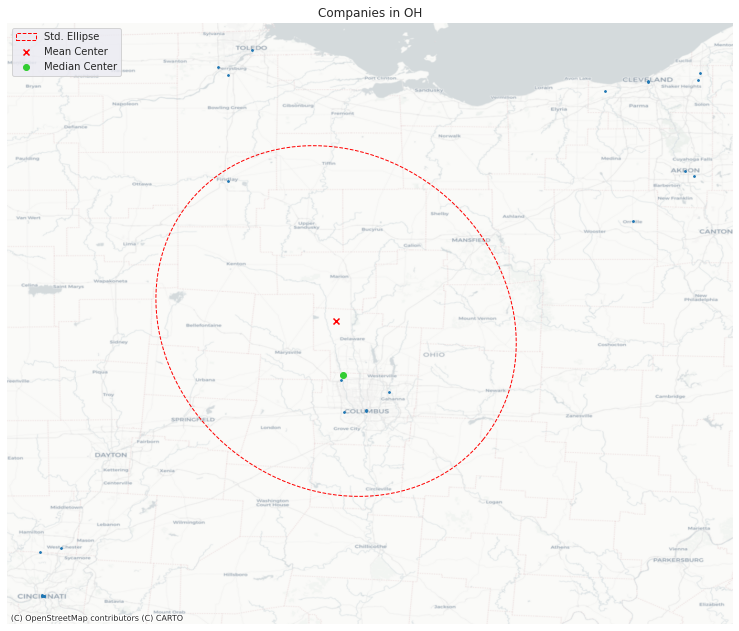

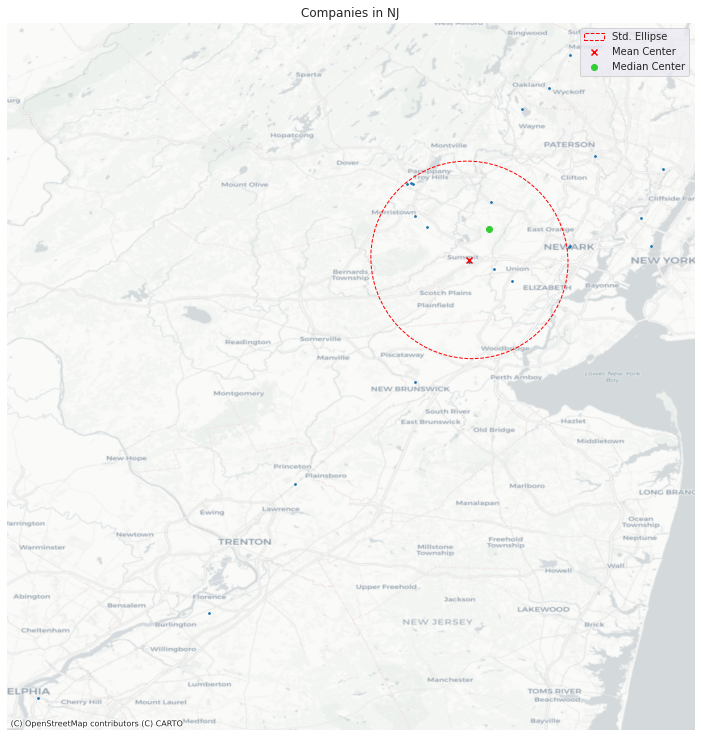

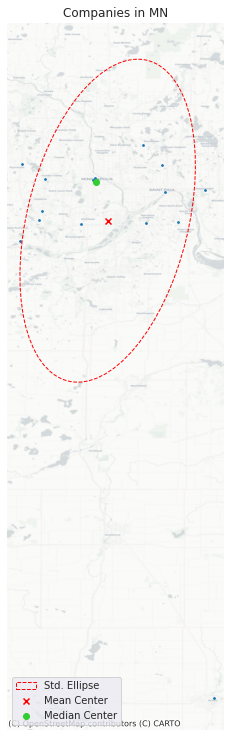

In [17]:
# get top 10 states
top10states = companies_gdf['STATE'].value_counts().head(10).index.tolist()
for state in top10states:
    company_ellipse(state)

The above are 10 different maps of companies by state (top 10 states) including the mean center, median center, and std. ellipse.

We know have an understanding of what companies have the highest influence of the stock market but we still don't know why. Lets go back to our companies filtered by size.

In [18]:
companies_huge_df

Symbol                  Name                  Sector    Market Cap
27   GOOGL  Alphabet Inc Class A  Information Technology  733823966137
28    GOOG  Alphabet Inc Class C  Information Technology  728535558140
30    AMZN        Amazon.com Inc  Consumer Discretionary  685873374731
51    AAPL            Apple Inc.  Information Technology  809508034020
311   MSFT       Microsoft Corp.  Information Technology  689978437468

We can see that all the huge (market cap greater than 600 Billion USD) companies with an exception of Amazon.com Inc (which is also commonly known as a "Technology Company" or Information Technology) are in the Information Technology Sector. Now let us take a look at the smaller (market cap less than 5 Billion) companies.

In [19]:
companies_small_df

Symbol                   Name                  Sector  Market Cap
57     AIZ           Assurant Inc              Financials  4653993594
104    CHK      Chesapeake Energy                  Energy  2626102121
170   EVHC    Envision Healthcare             Health Care  4212729247
324   NAVI                Navient              Financials  3692691330
353   PDCO    Patterson Companies             Health Care  3209792400
386    RRC  Range Resources Corp.                  Energy  3255587970
412    SIG        Signet Jewelers  Consumer Discretionary  3034275549

We can see that not one of these companies are in the Information Technology Sector. This leads to the question, are companies in the Information Technology sector worth more than companies that are not in the Information Technology sector? One explanation is hype. Technology is still a buzz word and investors cannot help themselves when it comes to "technology" companies. [What's Behind Technological Hype?](https://issues.org/behind-technological-hype/) elaborates on how this reduces overall innovation and how start-ups like Uber and Lyft lose a significant amount of money during the initial public offering (IPO) because they are over evaluated. The technology bubble is similar to that of the dot com bubble except we are dealing with very very large values. Let's look at an example with two companies we are familiar with it, Apple [Apple’s total net sales amounted to 260.17 billion U.S. dollars in their 2019 financial year](https://www.statista.com/statistics/265125/total-net-sales-of-apple-since-2004/#:~:text=Apple's%20total%20net%20sales%20amounted,in%20the%20last%20ten%20years.) and Walmart [Walmart ... generating revenues of almost 524 billion U.S. dollars in its most recent fiscal year.](https://www.statista.com/statistics/555334/total-revenue-of-walmart-worldwide/). We can clearly see from the statistics provided in these articles that in the year 2019 Walmart had a lot more revenue than Apple, to be exact 263.83 billion dollars more, a little over two times the revenue; so why isn't Walmart ranked higher than Apple? Let me rephrase that, why isn't Walmart even apart of the companies that have a market cap greater than 600 Billion? A reasonable explanation would be that maybe after costs are taken into account Walmart has a lower profit margin than Apple; but that is completely false. In fact, in the year 2020 Walmart had an annual gross profit of 129.359 Billion and Apple had an annual gross profit of 98.392 Billion according to [Walmart Gross Profit](https://www.macrotrends.net/stocks/charts/WMT/walmart/gross-profit) and [Apple Gross Profit](https://www.macrotrends.net/stocks/charts/AAPL/apple/gross-profit). Therefore, it's obvious that since their main distinction is their sector Information technology vs Non-Information Technology (in this case consumer services) that Apple is Hyped. But this is not just a hype that perhaps trends on the surface of social media and does not affect anybody. This hype is producing sever over evaluation of technology companies, not just Apple, but most if not all technology companies. Imagine the effects on our economy when the bubble bursts, the stock of many over evaluated companies will drop in almost an instance, it will be trillions of dollars essentially vanishing. This catastrophe will cause shock waves around the world on every economy.

By Ariel Hanasab